## Dendrogram extraction of HVCCs in CS cube:
Written by Sophia Kempe and Jennifer Wallace with contributions from Jakub Poznanski


In [1]:
import numpy as np                          # For math and working with arrays
import matplotlib                           # For plotting! Lots of documentation online
import matplotlib.pyplot as plt
import astropy.io.fits as fits              # For importing the FITS image 
from astropy.table import Table, join, vstack     # Used for creating tables via astropy
from astropy.wcs import WCS                 # For adding coordinates to images
from astropy import units as u              # Helps with unit conversion!
from spectral_cube import SpectralCube      # Useful package for working with 3D data cubes
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
from astropy.stats import mad_std
import astrodendro
from astrodendro import dendrogram 
from astrodendro.analysis import PPStatistic
from astrodendro.structure import Structure
from matplotlib.patches import Rectangle
from regions import Region, RectanglePixelRegion, RectangleSkyRegion, Regions
from astropy.visualization import LogStretch, SqrtStretch, PercentileInterval, ImageNormalize
import glob
import os

#%matplotlib qt (this is commented out unless you want to use the astrodendro interactive plot feature)

# Set up file paths: 
basepath = '/home/j_poz/documents/milkywaylab/data'
#drivepath = "G:/Shared drives/ACES/Paper Sprints/Inflow_EVFs" #f'/Users/jenniferwallace/Library/CloudStorage/GoogleDrive-jenwalls731@gmail.com/Shared drives/ACES/Documents/WP documents/WP2: Fundamental Measurements/Paper Sprints/Inflow_EVFs/DATA/CS_PV_slices/'
file= basepath+ '/images/CS21_CubeMosaic_downsampled9.fits'

In [2]:
# This is just a cell I use to change plotting parameters for the whole notebook at once
params = {
    ## ********************************************************************************
    ## * General Settings
    ## ********************************************************************************
    'image.cmap': 'magma',#'bone_r', 			#Change the colormap for images when using imshow
    'savefig.dpi': 375,  			#to adjust notebook inline plot size
    'text.usetex': False,#True,            		#Use LaTeX to render. Allows you to use LaTeX for the figure text (axes, labels, etc.), but increases render time. 
    								#I usually disable LaTeX for making plots quickly in Jupyter, as otherwise it takes rather long to display. You must have LaTeX on your computer for this to work!
    'font.family': 'sans-serif',			#Options: serif, sans-serif, cursive, fantasy, monospace 
    'figure.autolayout': True,      		#This applies 'tight_layout' to the plot to make the plot fit the fig, useful when saving plots
    
    ## ********************************************************************************
    ## * Axes Settings
    ## ********************************************************************************
    'axes.linewidth': 1,			#Makes the plot edges thicker, is 0.8 by default
    'axes.grid': False,				#display grid or not
    #'axes.grid.which': 'major',			#gridlines at {major, minor, both} ticks
    'axes.labelsize': 18, 			#fontsize for x and y labels
    'axes.edgecolor': 'k', 			#
    'font.size': 18, 				#fontsize for annotations etc.
    #'legend.fontsize': 14, 			#fontsizez for legend text
    #'legend.frameon': False, 			#removes the border around the legend box when set to 'False'
    #'legend.markerscale': 1.0, 			#the relative size of legend markers vs. original
    
    ## ********************************************************************************
    ## * x-axis settings
    ## ********************************************************************************
    'xtick.labelsize': 14, 			#fontsize of the x-tick labels
    'xtick.color': 'k', 			#fontsize of the x-tick labels
    'xtick.major.size': 5,			#length of major x-tick
    'xtick.major.width': 1,			#width of major x-tick
    #'xtick.minor.size': 5,			#length of minor x-tick
    #'xtick.minor.width': 1,			#width of minor x-tick
    'xtick.major.top'    : True ,   		#draw x axis top major ticks
    'xtick.major.bottom' : True ,   		#draw x axis bottom major ticks
    #'xtick.minor.top'     : True,   		#draw x axis top minor ticks
    #'xtick.minor.bottom' : True ,   		#draw x axis bottom minor ticks
    'xtick.direction': 'in',			#direction x-ticks point
    #'xtick.minor.visible' : True,   		#Quick toggle minor x-ticks on/off

    ## ********************************************************************************
    ## * y-axis settings
    ## ********************************************************************************    
    'ytick.labelsize': 14, 			#fontsize of the y-tick labels
    'ytick.color': 'k', 			#fontsize of the x-tick labels
    'ytick.major.size': 5,			#length of major y-tick
    'ytick.major.width': 1,			#width of major y-tick
    #'ytick.minor.size': 5,			#length of minor y-tick
    #'ytick.minor.width': 1,			#width of minor y-tick
    'ytick.major.left'    : True ,  		#draw y-axis left major ticks
    'ytick.major.right' : True ,   		#draw y-axis right major ticks
    #'ytick.minor.left'     : True,  		#draw y-axis left minor ticks
    #'ytick.minor.right' : True ,   		#draw y-axis right minor ticks
    'ytick.direction': 'in',			#direction y-ticks point
    #'ytick.minor.visible' : True,   		#Quick toggle minor y-ticks on/off
}
matplotlib.rcParams.update(params)

In [3]:
def is_coordinate_in_3d_range(point, min_corner, max_corner):
    """
    Checks if a 3D coordinate is within a specified 3D range.

    Args:
        point (tuple): A tuple (x, y, z) representing the 3D coordinate.
        min_corner (tuple): A tuple (min_x, min_y, min_z) representing the minimum corner of the range.
        max_corner (tuple): A tuple (max_x, max_y, max_z) representing the maximum corner of the range.

    Returns:
        bool: True if the point is within the range, False otherwise.
    """
    x, y, z = point
    min_x, min_y, min_z = min_corner
    max_x, max_y, max_z = max_corner

    return (min_x <= x <= max_x and
            min_y <= y <= max_y and
            min_z <= z <= max_z)

## Initialize CS data cube and grab by-eye ID table:

In [5]:

# Grab the CS data cube:
cube = SpectralCube.read(file)
sub_cube= cube       #can add .subcube(xlo=?*u.deg, xhi=?*u.deg, etc) to work with a smaller subcube  
wcs = sub_cube.wcs

# Calculate the beam area in deg^2 (gaussian area)
beam_omega_deg2 = (sub_cube.header['BMAJ']*sub_cube.header['BMIN']*np.pi)/(4*np.log(2))

# Convert beam parameters to get # of pixels in beam:
pix_area_deg2 = abs(sub_cube.header['CDELT1']) * abs(sub_cube.header['CDELT2'])
mpix = beam_omega_deg2/pix_area_deg2

# Grab the EVF by-eye ID table:
tbl = Table(ascii.read(f'{basepath}/tables/HVCC_resampled_again.ecsv'))
be_tbl = Table(ascii.read(f'{basepath}/tables/HVCC_resampled_table.ecsv'))

# Get EVF coords in pixels:
center_sky = SkyCoord(be_tbl['l'].to(u.rad), be_tbl['b'].to(u.rad), frame = 'galactic')

be_tbl['vert'] = np.divide(np.abs(be_tbl['deltaV']), np.abs(be_tbl['deltal'])) 
be_tbl['x_pix'], be_tbl['y_pix'] = center_sky.to_pixel(wcs)
be_tbl['v_pix'] =(((be_tbl['V_LSR'].data- sub_cube.header['CRVAL3'])/(sub_cube.header['CDELT3'] )) + sub_cube.header['CRPIX3'] )#.astype(int)

# Currently rounding values and not using int:
be_tbl['x_pix'] = [round(item) for item in be_tbl['x_pix']]
be_tbl['y_pix'] = [round(item) for item in be_tbl['y_pix']]
be_tbl['v_pix'] = [round(item) for item in be_tbl['v_pix']]

## Load the specific dendrogram you want:

In [6]:
cube_noise = mad_std(data=cube, ignore_nan=True)
min_val = 15         # Minimum value factor 15
min_sig = 10         # Minimum significance factor
scale = cube_noise   # CS Cube madstd rms noise value

In [ ]:
#dend = astrodendro.Dendrogram.compute(cube.unmasked_data[:].value, wcs = cube.wcs, min_value= min_val*scale, 
                                      #min_delta= min_sig*scale, min_npix=int(2*mpix))

# Read in the dendrogram:
dend = astrodendro.Dendrogram.load_from(f'{basepath}/tables/CS_HVCC_dendrogram_mv_'+str(min_val)+'_ms_'+str(min_sig)+'_mp_'+str(int(2*mpix))+'.fits')

## Generate the raw catalog from the dendrogram and then add columns:

In [ ]:
# Create the catalog from the dendrogram:
Metadata = {}

# Define the pixel size in arcseconds:
PixelAreaArcsec = 3600. * abs(sub_cube.header['CDELT1']) * 3600. * abs(sub_cube.header['CDELT2'])
Metadata['wcs'] = wcs
# Define the pixel units in the image input to the dendrogram:
Metadata['data_unit'] = u.Jy / u.beam
# Define the pixel size (on one side):
Metadata['spatial_scale'] =  PixelAreaArcsec**0.5 * u.arcsec
Metadata['velocity_scale'] = sub_cube.header['CDELT3'] * u.m/u.s
# Define the beam parameters (since pixel units are Jy/beam):
Metadata['beam_major'] = (3600 * sub_cube.header['BMAJ'])*u.arcsec
Metadata['beam_minor'] = (3600 * sub_cube.header['BMIN'])*u.arcsec

catalog = astrodendro.ppv_catalog(dend, Metadata, verbose=False)

catalog['idx'] = [structure.idx for structure in dend]
indices = [dend[index].indices() for i, index in enumerate(catalog['idx'])]

catalog['vmax_pix'], catalog['vmin_pix'] = zip(*[(max(idx[0]), min(idx[0])) for idx in indices])
catalog['lmax_pix'], catalog['lmin_pix'] = zip(*[(max(idx[2]), min(idx[2])) for idx in indices])
catalog['bmax_pix'], catalog['bmin_pix'] = zip(*[(max(idx[1]), min(idx[1])) for idx in indices])
#convert to WCS
sky_coords, velocity_coords = wcs.pixel_to_world(catalog['lmax_pix'], catalog['bmax_pix'], catalog['vmax_pix'])
catalog['lmax_u'], catalog['bmax_u'] = sky_coords.l.deg, sky_coords.b.deg
catalog['vmax_u'] = velocity_coords
sky_coords, velocity_coords = wcs.pixel_to_world(catalog['lmin_pix'], catalog['bmin_pix'], catalog['vmin_pix'])
catalog['lmin_u'], catalog['bmin_u'] = sky_coords.l.deg, sky_coords.b.deg
catalog['vmin_u'] = velocity_coords

catalog['lmax_u'] = np.where(catalog['lmax_u'] > 180, catalog['lmax_u'] - 360, catalog['lmax_u']) #make sure negative values are negative now
catalog['lmin_u'] = np.where(catalog['lmin_u'] > 180, catalog['lmin_u'] - 360, catalog['lmin_u']) # this is most important for over the boundary of l=0

catalog['del_v']= catalog['vmax_u']-catalog['vmin_u']
catalog['del_l']= catalog['lmax_u']-catalog['lmin_u']
catalog['del_b']= catalog['bmax_u']-catalog['bmin_u']

# Removes sources with a longitude extent == 0:
catalog=catalog[(catalog['del_l']!= 0)] 

catalog['verticality'] = np.divide(np.abs(catalog['del_v']), np.abs(catalog['del_l'])) 
catalog['verticality'].unit = u.m/(u.s*u.deg)

peakl,peakb,peakv = [dend[index].get_peak()[0][2] for i, index in enumerate(catalog['idx'])], [dend[index].get_peak()[0][1] for i,index in enumerate(catalog['idx'])], [dend[index].get_peak()[0][0] for i,index in enumerate(catalog['idx'])]
peak_sky_coords, peak_velocity_coords = wcs.pixel_to_world(peakl, peakb, peakv)
catalog['l_peak'], catalog['b_peak'] = peak_sky_coords.l.deg, peak_sky_coords.b.deg
catalog['v_peak']= peak_velocity_coords

#catalog.write('/Users/jenniferwallace/Documents/Research/ACES/CS_HVCC_fullcatalog_mv_'+str(min_val)+'_ms_'+str(min_sig)+'_mp_'+str(int(2*mpix))+'.fits', 
              #overwrite=True)

## Load dendrogram catalog!
Can maybe add some code here that removes some unecessary columns

In [18]:
tbl[:164]

ID Number,l,b,deltal,deltab,V_LSR,deltaV,Verticality,Size,Median Intensity,Spectrum FWHM,min_v,max_v,Classification Comments,dendro_match
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str55,float64
0,-0.282,0.055,0.03166492702081314,0.021943929388070445,-44.53479599999999,28.2053708,890.745,2.596173840394772,0.132,nan,-50.4727688,-22.267397999999996,--,3322.0
1,-0.261,0.024,0.024998767616750683,0.03430464701758619,-93.5230716,51.957261999999986,2078.393,3.072800395030589,0.09,nan,-120.24394919999999,-68.2866872,Includes a velocity end - Oka+2012 classification,774.0
2,-0.307,0.03,0.024165193107819505,0.028332504368318343,-32.6588504,23.751891199999996,982.897,2.433568196064372,0.129,nan,-43.0503028,-19.2984116,--,4435.0
3,-0.462,-0.256,0.010554407729784998,0.009443898054820377,-96.49205799999999,29.689864,2813.03,2.2225571728052143,0.116,nan,-124.6974288,-95.0075648,--,345.0
4,-0.382,-0.253,0.03485818720434963,0.02083201845320018,20.782904799999997,26.720877599999998,766.56,2.490929026403545,0.128,nan,5.9379728,32.6588504,Dendrogram detection doesn't meet verticality threshold,nan
5,-0.401,-0.131,0.03652447436735429,0.02652655979178853,10.391452399999999,43.0503028,1178.67,3.4092383944864926,0.112,nan,-13.3604388,29.689864,--,7889.0
6,-0.507,-0.212,0.0013887116846831304,0.0012499211998702742,-115.7904696,5.937972800000011,4275.886,1.5683208096861325,0.181,nan,-118.759456,-112.82148319999999,--,162.0
7,-0.432,-0.195,0.005971620353989238,0.007082962281781624,-26.7208776,19.298411599999998,3231.688,1.3239879035981668,0.145,nan,-35.6278368,-16.3294252,--,4465.0
8,-0.473,-0.137,0.00249970624645357,0.0029165409467419023,-60.864221199999996,14.844932,5938.671,1.2561353243348417,0.134,nan,-72.7401668,-57.8952348,--,2012.0


In [20]:
len(np.where(np.isnan(tbl['dendro_match'][:164]))[0])

23

In [8]:
#Read in the dendro catalog:
catalog = Table.read(f'{basepath}/tables/CS_HVCC_fullcatalog_mv_'+str(min_val)+'_ms_'+str(min_sig)+'_mp_'+str((2*mpix))+'.fits')

In [15]:
# Create a mask that removes sources based on verticality, l extent and v extent:
cat_mask = (((catalog['lmax_pix']-catalog['lmin_pix'])>=2.) 
            & (catalog['verticality'] >= 1000000)
            & ((catalog['lmax_pix']-catalog['lmin_pix'])<=56.)
            &(catalog['del_v'] > 50000))

masked_cat = catalog[cat_mask]


## Cell for seeing which structures from the free dendrogram 

In [26]:
d = []

for i, ids in enumerate(masked_cat['idx']):
    zyx, peak_val = dend[ids].get_peak()

    pix_coords = (zyx[2],zyx[1],zyx[0])
    
    x=[]
    area= []
    

    for s, struc in enumerate(masked_cat['idx']):
        cond = is_coordinate_in_3d_range(pix_coords,
                                        (masked_cat['lmin_pix'][s], masked_cat['bmin_pix'][s],  masked_cat['vmin_pix'][s]), 
                                        (masked_cat['lmax_pix'][s], masked_cat['bmax_pix'][s], masked_cat['vmax_pix'][s])) 
        
        if cond == True:
       
            x.append(struc)

            area.append(masked_cat['area_exact'][s])

        
    if x == []:
        d.append(np.nan)

    else:
        x = np.array(x)
        area = np.array(area)
        max_x = x[area == np.nanmax(area)]
        
        d.append(max_x[0]) # Only want the largest structure!

d = np.array(d)
masked_cat.add_index('idx')

masked_cat = masked_cat.loc[np.unique(d[~np.isnan(d)])] # Making sure we only keep the largest structure at a given position

#masked_cat.write(dir+'ACES/CS_HVCC_fullcatalog_mv_15_ms_10_mp_2_free.fits', overwrite=True)

## If you want to know which by-eye IDs have an associated dendrogram structure:

In [16]:
# Create a mask that removes sources based on verticality, l extent and v extent:
# This is for confirming detections, so we use the more lenient thresholds:
confirm_mask = (((catalog['lmax_pix']-catalog['lmin_pix'])>=2.) 
                & (catalog['verticality'] >= 1000000)
                & ((catalog['lmax_pix']-catalog['lmin_pix'])<=56.)
                & (catalog['del_v'] > 10000))

cat = catalog[confirm_mask]

In [21]:
tbl.add_index('dendro_match')

In [29]:
for i in tbl:
    if i['dendro_match'] < 0:
        print(i)

In [39]:
len(np.where(np.isnan(tbl[:164]['dendro_match']))[0])

23

In [17]:
d = [] # The structure ids for dendrogram structures
match = [] # A true or false list for whether a by-eye detection is associated with a dendrorgam structure

#Iterate through the by-eye table:
for c, coords in enumerate(tbl['l']):
    pix_coords = (tbl['x_pix'][c], tbl['y_pix'][c], tbl['v_pix'][c])
    
    x=[]
    area= []
    for s, struc in enumerate(cat['idx']):
        cond = is_coordinate_in_3d_range(pix_coords,
                                        (cat['lmin_pix'][s], cat['bmin_pix'][s],  cat['vmin_pix'][s]), 
                                        (cat['lmax_pix'][s], cat['bmax_pix'][s], cat['vmax_pix'][s])) 
        
        if cond == True:
       
            x.append(struc)
            area.append(cat['area_exact'][s])

        
    if x == []:
        d.append(np.nan)
        match.append(False)
    else:
        x = np.array(x)
        area = np.array(area)
        max_x = x[area == np.nanmax(area)]
        match.append(True)
        d.append(max_x[0]) # Use .extend(x) instead if you want all of the structures containing the given coordinate (nested)

d = np.array(d)
tbl['dendro_match'] = d # or match, whatever you want to do 

#tbl.write('/Users/jenniferwallace/Documents/Research/EVF_sprint_2025/HVCC_resampled_table_with_dendmatch_column.fits', overwrite=True)

KeyError: 'x_pix'

In [ ]:
match_tbl = be_tbl[~np.isnan(tbl['dendro_match'])]
match_tbl

masked_cat

d = [] # The structure ids for dendrogram structures
match = [] # A true or false list for whether a by-eye detection is associated with a dendrogram structure
#unique_dends = []

#Iterate through the by-eye table:
for c, coords in enumerate(match_tbl['l']):
    pix_coords = (match_tbl['x_pix'][c], match_tbl['y_pix'][c], match_tbl['v_pix'][c])
    
    x=[]
    area= []
    for s, struc in enumerate(masked_cat['idx']):
        cond = is_coordinate_in_3d_range(pix_coords,
                                        (masked_cat['lmin_pix'][s], masked_cat['bmin_pix'][s],  masked_cat['vmin_pix'][s]), 
                                        (masked_cat['lmax_pix'][s], masked_cat['bmax_pix'][s], masked_cat['vmax_pix'][s])) 
        
        if cond == True:
       
            x.append(struc)
            area.append(masked_cat['area_exact'][s])
            

        
    if x == []:
        d.append(np.nan)
        match.append(False)
    else:
        x = np.array(x)
        area = np.array(area)
        max_x = x[area == np.nanmax(area)]
        match.append(True)
        d.append(max_x[0]) # Use .extend(x) instead if you want all of the structures containing the given coordinate (nested)

d = np.array(d)
print("There are", 108-len(np.unique(d[~np.isnan(d)])), "unique dendrogram structures that are not associated with a by-eye detection.")
catalog

In [29]:
d = []
b = []

for c, coord in enumerate(tbl['l']):
    pix_coords = (tbl['x_pix'][c], tbl['y_pix'][c], tbl['v_pix'][c])

    x=[]
    num = []
    for s, struc in enumerate(dend.all_structures):
        if struc.idx not in masked_cat['idx']:
            continue
        # If you want to only keep leaf structures:
        # Commented out because it does NOT recover most EVFs
        #if struc.is_leaf == True:
            #continue
            
        cond = is_coordinate_in_3d_range(pix_coords,
                                        (np.nanmin(struc.indices()[2]), np.nanmin(struc.indices()[1]),  np.nanmin(struc.indices()[0])), 
                                         (np.nanmax(struc.indices()[2]), np.nanmax(struc.indices()[1]),  np.nanmax(struc.indices()[0]))) 
        if cond == True:
       
            x.append(struc.idx)
            num.append(struc.get_npix())
        
    if x == []:
        d.append(np.nan)
    else:
        x = np.array(x)
        num = np.array(num)
        max_x = x[num == np.nanmax(num)]
        
        d.extend(x)#append(max_x[0]) #Use append(max_x[0] instead if you just want the largest structure containing the given coordinate

d = np.array(d)
masked_cat.add_index('idx')

masked_cat = masked_cat.loc[np.unique(d[~np.isnan(d)])]


<Figure size 1400x1500 with 0 Axes>

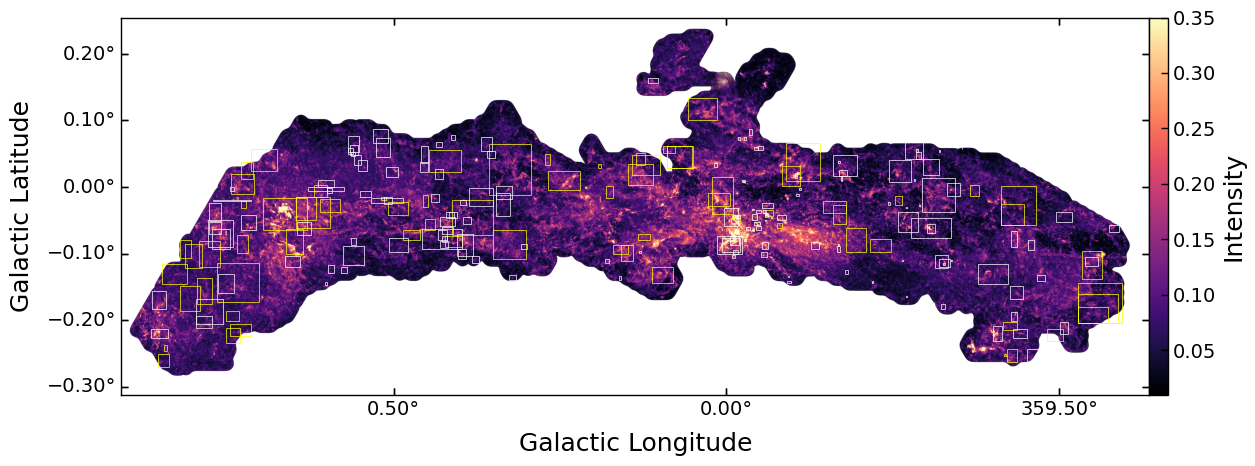

In [128]:
hdul_lb = fits.open(f'{basepath}/Images/CS21_CubeMosaic_max.fits')[0] ### I'll figure this path out later
hdu_data_lb = hdul_lb.data
header_lb = hdul_lb.header
wcs_lb = WCS(header_lb)
fig1 = plt.figure(figsize=(14, 15))
gs = fig1.add_gridspec(3, 2)


fig1, ax1 = plt.subplots(figsize=(20, 5),subplot_kw={'projection': wcs_lb})#projection=wcs, slices=('x', 'y', 50)))
#fig1.add_subplot(gs[0, :], projection=wcs_lb)

im1 = ax1.imshow(hdu_data_lb, origin='lower', cmap='magma', vmin = 0.01, vmax = 0.35)


# Plot dendrogram EVF extents

dend_regs = []
reg_list = []
for evf in tbl[151:]:
    center_sky = SkyCoord(evf['l'], evf['b'], unit = 'deg', frame = 'galactic')
    reg = RectangleSkyRegion(center_sky, width = evf['deltal']*u.deg, height = evf['deltab']*u.deg)
    pixel_region = reg.to_pixel(wcs_lb)
    
    dend_regs.append(pixel_region)


for struc in dend_regs:
    struc.plot(ax=ax1, color='yellow', linewidth=0.5)
        

reg_list = []
for evf in tbl[:151]:
    center_sky = SkyCoord(evf['l'], evf['b'], unit = 'deg', frame = 'galactic')
    reg = RectangleSkyRegion(center_sky, width = evf['deltal']*u.deg, height = evf['deltab']*u.deg)
    pixel_region = reg.to_pixel(wcs_lb)
    
    reg_list.append(pixel_region)

for evf in reg_list:
    evf.plot(ax=ax1, color='white', linewidth=0.5)

    
plt.colorbar(im1, ax = ax1, label = 'Intensity', pad=0)

lon1 = ax1.coords['glon']
lat1 = ax1.coords['glat']
lon1.set_major_formatter('d.dd')
lat1.set_major_formatter('d.dd')
ax1.set_ylabel('Galactic Latitude')
ax1.set_xlabel('Galactic Longitude')
#ax1.set_xlim(0.3, 0.6)
#fig1.savefig("/Users/jenniferwallace/Documents/Research/ACES/cs_evfs.pdf", bbox_inches='tight')

plt.tight_layout()

In [30]:
hvcc_tbl = Table(names=tbl.colnames)
dend_id = []

for i, idx in enumerate(cat['idx']):
    if idx not in d[~np.isnan(d)].astype(int):
        
        hvcc_tbl.add_row(vals=[i, cat[i]['lmax_u']-(cat[i]['del_l']/2), cat[i]['bmax_u']-(cat[i]['del_b']/2), np.abs(cat[i]['del_l']), 
                         cat[i]['del_b'], cat[i]['vmax_u']-(cat[i]['del_v']/2), cat[i]['del_v'], cat[i]['verticality'], np.nan, 
                         np.nan, np.nan, cat[i]['vmin_u'], cat[i]['vmax_u'], np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, idx])
       
        dend_id.append(cat[i])
        
hvcc_tbl['Classification Comments'] = hvcc_tbl['Classification Comments'].astype(str)
new_tbl = vstack([tbl, hvcc_tbl])
new_tbl.remove_columns(['vert', 'x_pix', 'y_pix', 'v_pix'])
new_tbl['ID Number'] = np.arange(len(new_tbl))

dend_id = Table(dend_id)

In [18]:
tbl.write(f'{basepath}/tables/HVCC_resampled_again.ecsv', overwrite = True)

In [153]:
subcube_tbl = tbl['ID Number', 'l', 'b', 'deltal', 'deltab', 'min_v', 'max_v']

subcube_tbl['deltal'] = abs(subcube_tbl['deltal'])

subcube_tbl['deltal'] += .005
subcube_tbl['deltab'] += .005

In [154]:
d = np.full(fill_value='d', shape=len(subcube_tbl[164:]))
e = np.full(fill_value='e', shape=len(subcube_tbl[:164]))

r = np.concatenate((e,d))

subcube_tbl['detection_method'] = r

In [155]:
subcube_tbl['ID Number'] = np.arange(len(subcube_tbl))

In [118]:
for n in subcube_tbl.colnames:
    if np.nan in subcube_tbl[n].data:
        print(n)

In [6]:
subcube_tbl = Table.read(f'{basepath}/tables/HVCC_resampled_subcube_regions.ecsv')

In [10]:
subcube_tbl.write(f'{basepath}/tables/HVCC_resampled_subcube_regions.ecsv', overwrite =True)

In [123]:
(tbl['deltal']) = abs(tbl['deltal'])
(tbl['deltab']) = abs(tbl['deltab'])

In [145]:
for i, row in enumerate(tbl):
    if abs(row['deltaV']) >= 300:
        tbl[i]['min_v']/=1000
        tbl[i]['max_v']/=1000
        tbl[i]['V_LSR']/=1000
        tbl[i]['deltaV']/=1000
#subcube_tbl.write(f'{basepath}/tables/HVCC_resampled_subcube_regions.ecsv', overwrite =True)

In [48]:
x=[]
for i, row in enumerate(be_tbl['l', 'b', 'deltal', 'deltab']):
    if row not in tbl['l','b','deltal', 'deltab']:
        x.append(i)

In [42]:
for i, row in enumerate(tbl):
    if row['dendro_match'] in catalog['_idx']:
        tbl['l'][i] = catalog.loc[int(row['dendro_match'])]['x_cen']
        tbl['b'][i] = catalog.loc[int(row['dendro_match'])]['y_cen']
        tbl['deltab'][i] = catalog.loc[int(row['dendro_match'])]['del_b']
        tbl['deltal'][i] = catalog.loc[int(row['dendro_match'])]['del_l']

In [53]:
tbl.add_index('deltal')

In [50]:
catalog.add_index('del_l')

In [55]:
for i in tbl:
    if i['deltal'] > 0.1: 
        print(i)